In [735]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [736]:
df = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')

# Create copy to keep original data
songs = df.copy()

# Prints the first 5 rows
print(songs.head())

                            track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA       Myke Towers             1   
2                              vampire    Olivia Rodrigo             1   
3                         Cruel Summer      Taylor Swift             1   
4                       WHERE SHE GOES         Bad Bunny             1   

   released_year  released_month  released_day  in_spotify_playlists  \
0           2023               7            14                   553   
1           2023               3            23                  1474   
2           2023               6            30                  1397   
3           2019               8            23                  7858   
4           2023               5            18                  3133   

   in_spotify_charts    streams  in_apple_playlists  ...  bpm key   mode  \
0                147  141381703               

In [737]:
# Prints data types of each column
print(songs.dtypes)

track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object


In [738]:
# Remove commas and convert to numeric for the relevant columns
columns_to_convert = ['streams', 'in_deezer_playlists', 'in_shazam_charts']

# Remove commas and convert objects to numeric
for col in columns_to_convert:
    # Remove commas and replace non-numeric characters (if any)
    songs[col] = songs[col].str.replace(',', '', regex=False)

    # Convert to numeric, coercing errors to NaN
    songs[col] = pd.to_numeric(songs[col], errors='coerce')

# Check data types of each column
print(songs.dtypes)

track_name               object
artist(s)_name           object
artist_count              int64
released_year             int64
released_month            int64
released_day              int64
in_spotify_playlists      int64
in_spotify_charts         int64
streams                 float64
in_apple_playlists        int64
in_apple_charts           int64
in_deezer_playlists       int64
in_deezer_charts          int64
in_shazam_charts        float64
bpm                       int64
key                      object
mode                     object
danceability_%            int64
valence_%                 int64
energy_%                  int64
acousticness_%            int64
instrumentalness_%        int64
liveness_%                int64
speechiness_%             int64
dtype: object


In [739]:
# Check for any NaN values after conversion
print(songs.isnull().sum())

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  1
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


In [740]:
#Data Imputation

# Drop single null stream
songs.dropna(subset=['streams'], inplace=True)

# Drop irrelevant columns
songs = songs.drop(columns=['track_name', 'artist(s)_name'])

# Impute 'in_shazam_charts' empty values with median
songs['in_shazam_charts'].fillna(songs['in_shazam_charts'].median(), inplace=True)

# Impute 'key' with the most frequent key
most_frequent_key = songs['key'].mode()[0]  # get the most frequent value
songs['key'].fillna(most_frequent_key, inplace=True)

<ipython-input-740-5c0f4a5daec6>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  songs['in_shazam_charts'].fillna(songs['in_shazam_charts'].median(), inplace=True)
<ipython-input-740-5c0f4a5daec6>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

In [741]:
# check null values again
print(songs.isnull().sum())

artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


In [742]:
# Convert percentage columns to decimals
percentage_columns = ['danceability_%', 'energy_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'acousticness_%', 'valence_%']

# Convert percentage columns to decimal format (divide by 100)
for col in percentage_columns:
    songs[col] = songs[col] / 100

print(songs[percentage_columns].head())


   danceability_%  energy_%  instrumentalness_%  liveness_%  speechiness_%  \
0            0.80      0.83                0.00        0.08           0.04   
1            0.71      0.74                0.00        0.10           0.04   
2            0.51      0.53                0.00        0.31           0.06   
3            0.55      0.72                0.00        0.11           0.15   
4            0.65      0.80                0.63        0.11           0.06   

   acousticness_%  valence_%  
0            0.31       0.89  
1            0.07       0.61  
2            0.17       0.32  
3            0.11       0.58  
4            0.14       0.23  


In [743]:
# Checks the number of 0's for numerical values
numerical_columns = songs.select_dtypes(include=['float64', 'int64']).columns  # Select numerical columns
zeros_count = (songs[numerical_columns] == 0).sum()  # Count zeros in numerical columns
print('\nZero Values in Numerical Columns:\n', zeros_count)


Zero Values in Numerical Columns:
 artist_count              0
released_year             0
released_month            0
released_day              0
in_spotify_playlists      0
in_spotify_charts       404
streams                   0
in_apple_playlists       23
in_apple_charts          99
in_deezer_playlists      24
in_deezer_charts        557
in_shazam_charts        343
bpm                       0
danceability_%            0
valence_%                 0
energy_%                  0
acousticness_%           60
instrumentalness_%      865
liveness_%                0
speechiness_%             0
dtype: int64


In [744]:
# Intrumentalness has high missing value. Check correlation with possible target value streams.
print(songs[['instrumentalness_%', 'streams']].corr())


                    instrumentalness_%   streams
instrumentalness_%            1.000000 -0.044902
streams                      -0.044902  1.000000


In [745]:
# Check correlation with possible target value in_spotify_charts.
print(songs[['instrumentalness_%', 'in_spotify_charts']].corr())

                    instrumentalness_%  in_spotify_charts
instrumentalness_%             1.00000           -0.01027
in_spotify_charts             -0.01027            1.00000


In [746]:
# Check for duplicates
print('Duplicates Found: ', songs.duplicated().sum())

Duplicates Found:  0


In [747]:
# Features exempt from Outlier Detection
# artist_count
# released_month
# released_day
# released_year



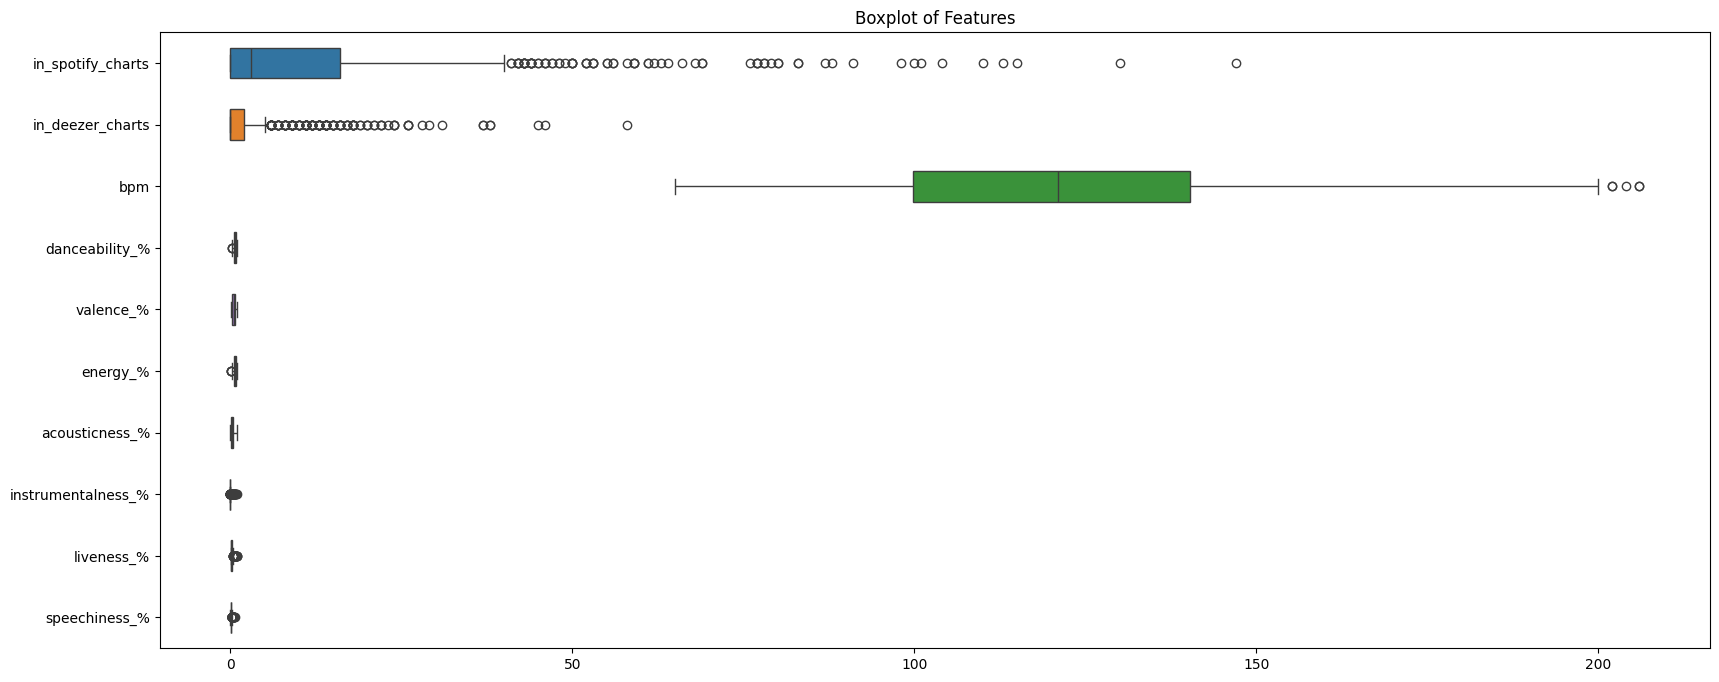

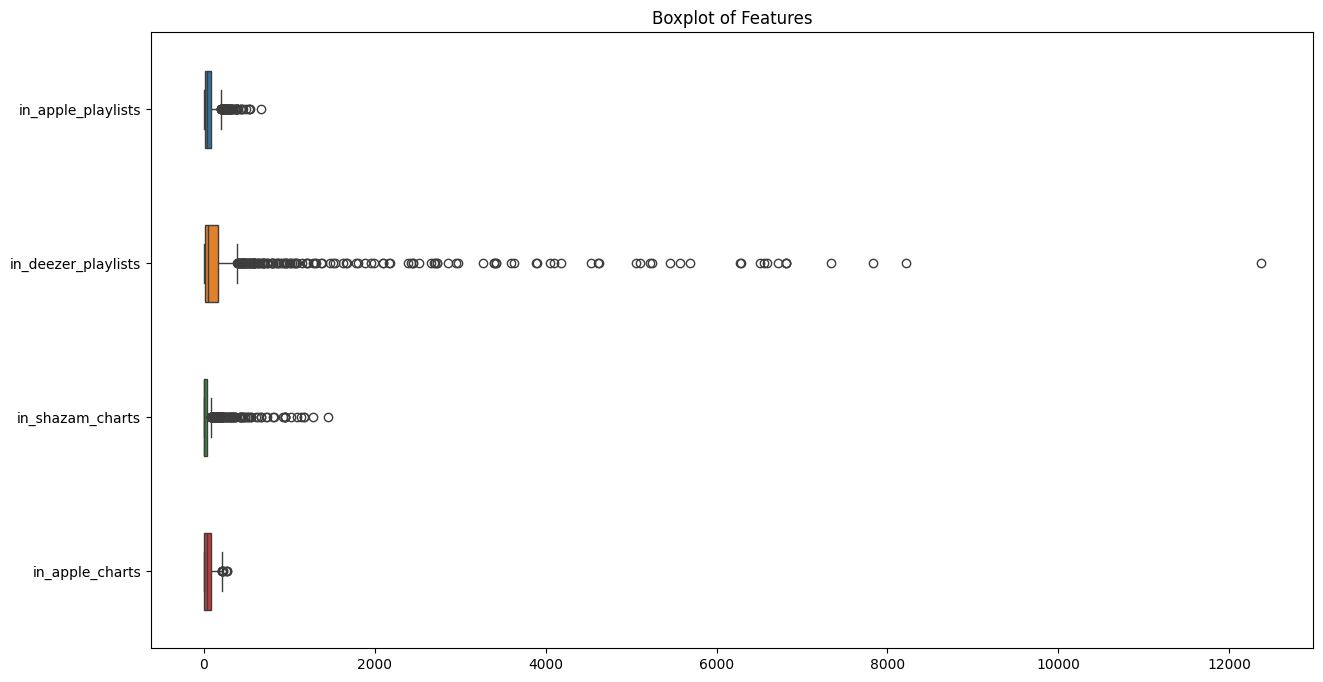

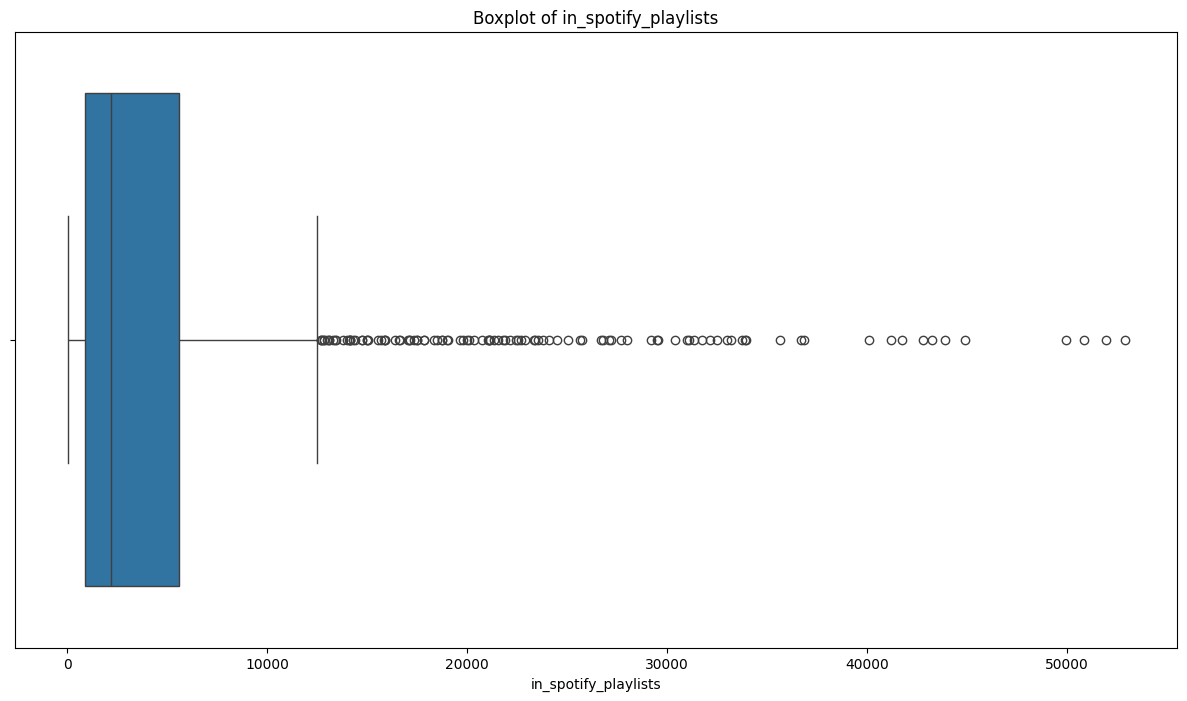

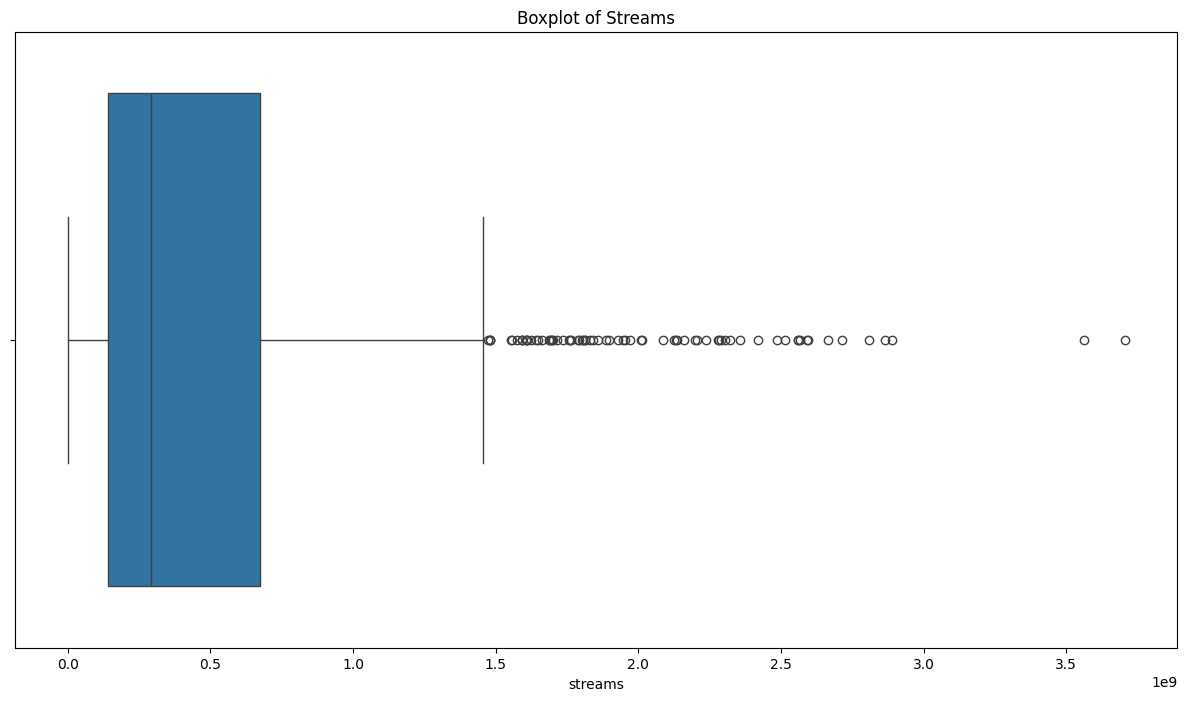

In [748]:
# Boxplot to detect outliers
plt.figure(figsize=(20, 8))
songs_without_column = songs.drop(columns=['artist_count','released_month','released_day','released_year','streams', 'in_spotify_playlists','in_shazam_charts','in_apple_charts','in_apple_playlists', 'in_deezer_playlists'])
sns.boxplot(data=songs_without_column, orient="h", width=0.5)
plt.title('Boxplot of Features')
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(15, 8))
columns = ['in_apple_playlists', 'in_deezer_playlists','in_shazam_charts','in_apple_charts']
sns.boxplot(data=songs[columns], orient="h", width=0.5)
plt.title('Boxplot of Features')
plt.show()

# Boxplot for in_spotify_playlists
plt.figure(figsize=(15, 8))
sns.boxplot(x=songs['in_spotify_playlists'])
plt.title('Boxplot of in_spotify_playlists')
plt.show()

# Boxplot for streams
plt.figure(figsize=(15, 8))
sns.boxplot(x=songs['streams'])
plt.title('Boxplot of Streams')
plt.show()

In [749]:
# Transform with Logs
columns_to_transform = ['streams', 'in_spotify_playlists']
songs[columns_to_transform] = songs[columns_to_transform].apply(np.log1p)

# Remove Outliers
columns_to_include = ['in_shazam_charts','in_apple_charts', 'in_deezer_charts', 'in_spotify_charts', 'in_apple_playlists', 'in_deezer_playlists', 'bpm', 'danceability_%', 'energy_%', 'instrumentalness_%', 'liveness_%', 'valence_%', 'speechiness_%','acousticness_%']
Q1 = songs[columns_to_include].quantile(0.25)
Q3 = songs[columns_to_include].quantile(0.75)
IQR = Q3 - Q1
songs = songs[~((songs[columns_to_include] < (Q1 - 1.5 * IQR)) | (songs[columns_to_include] > (Q3 + 1.5 * IQR))).any(axis=1)]

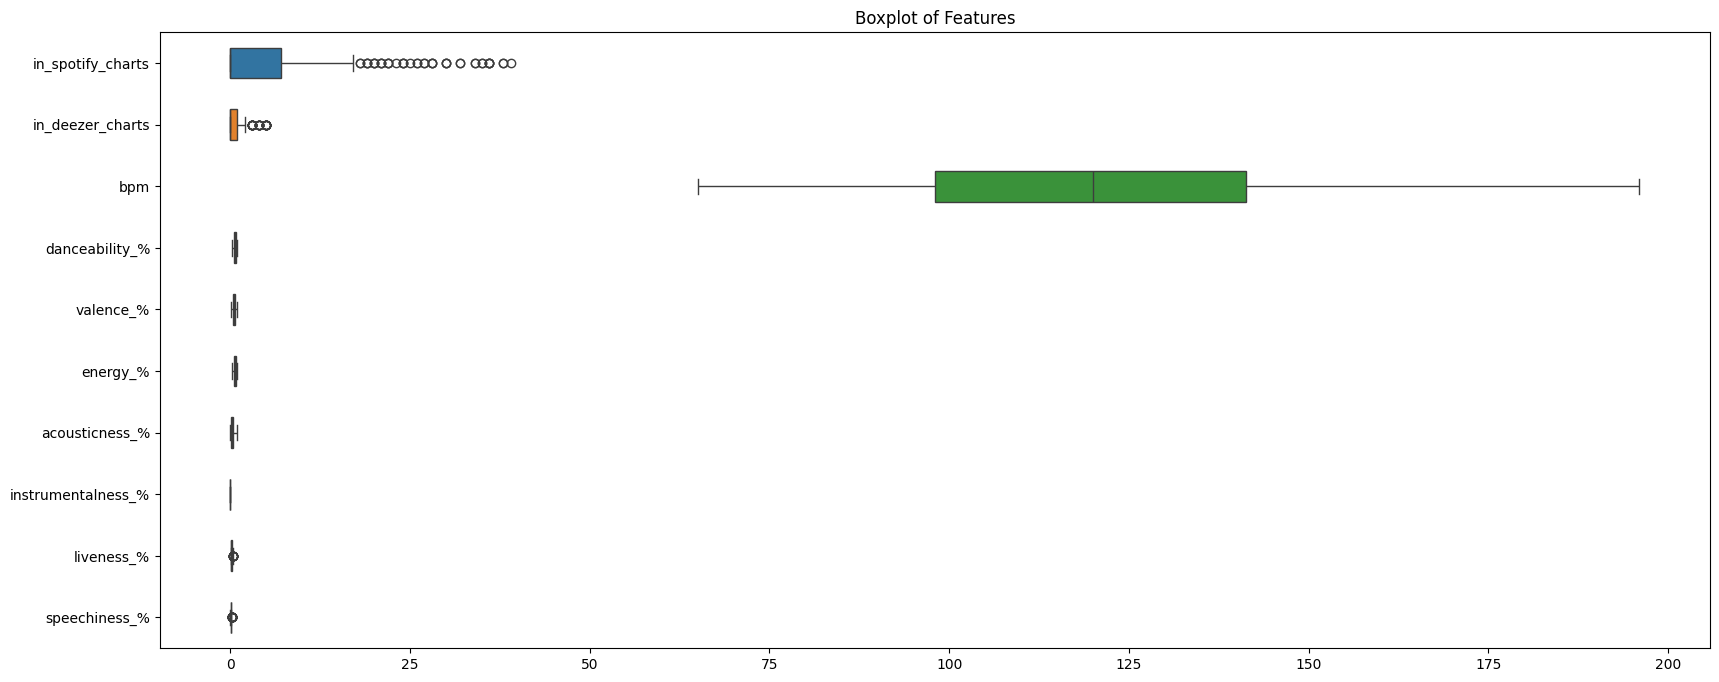

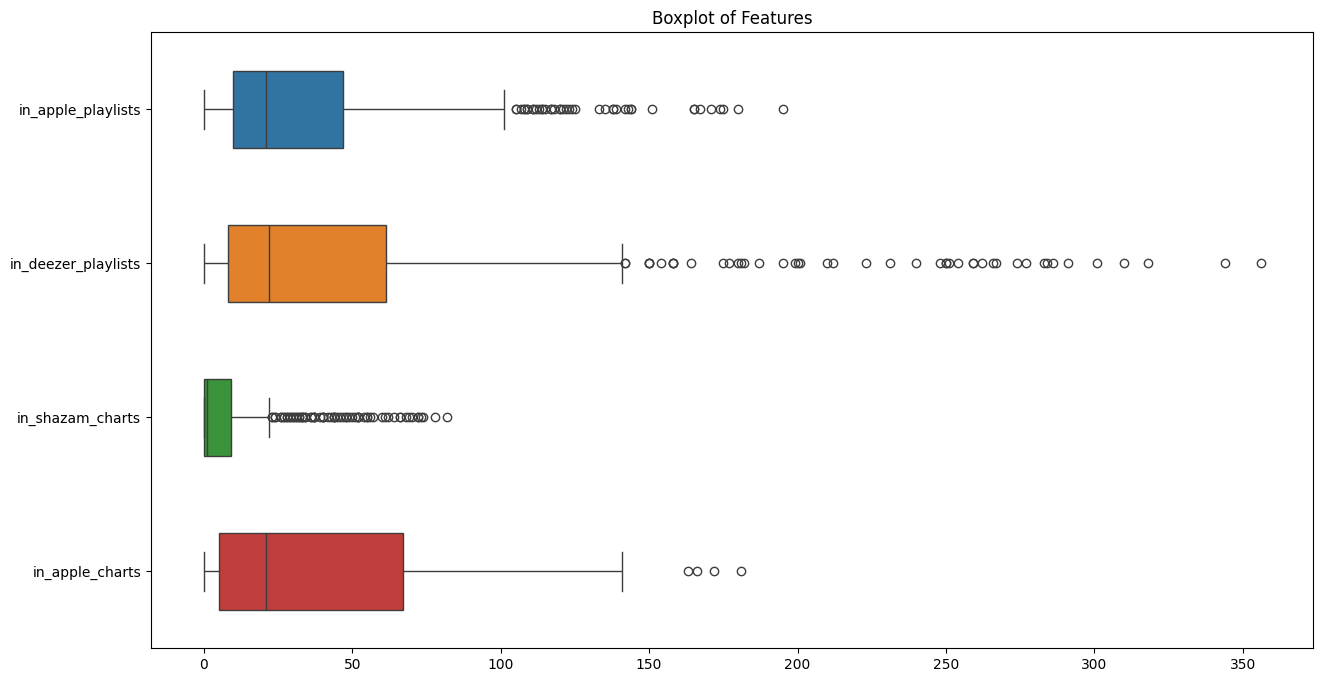

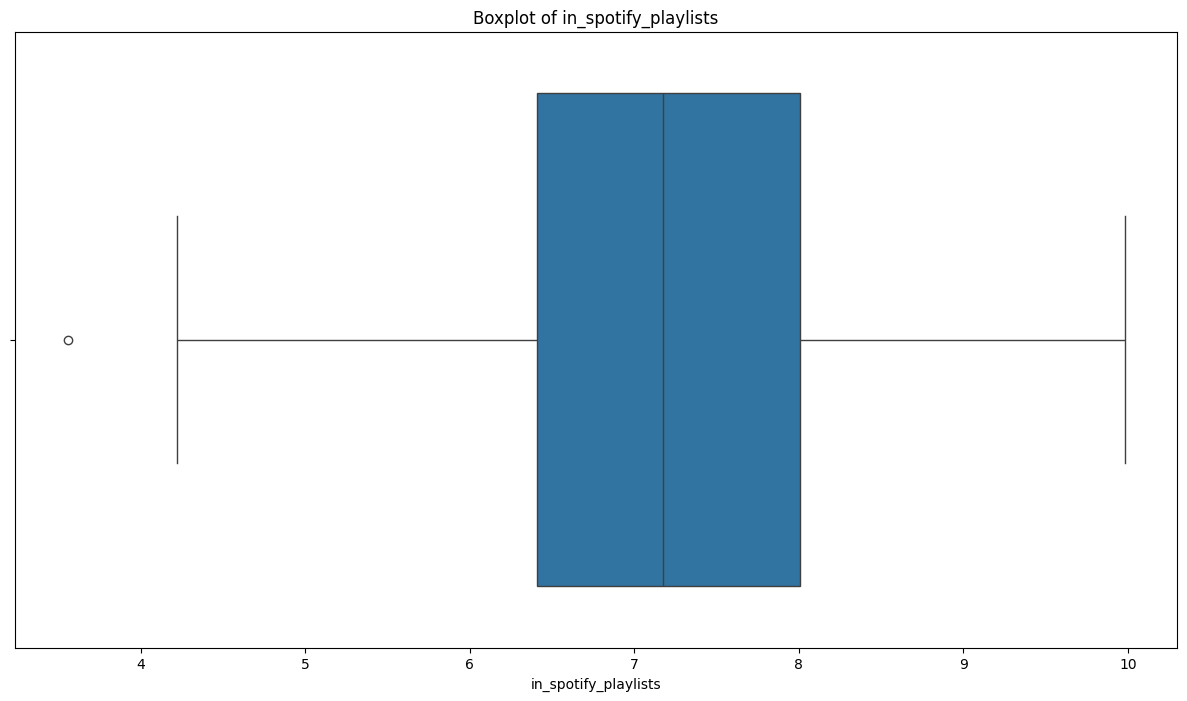

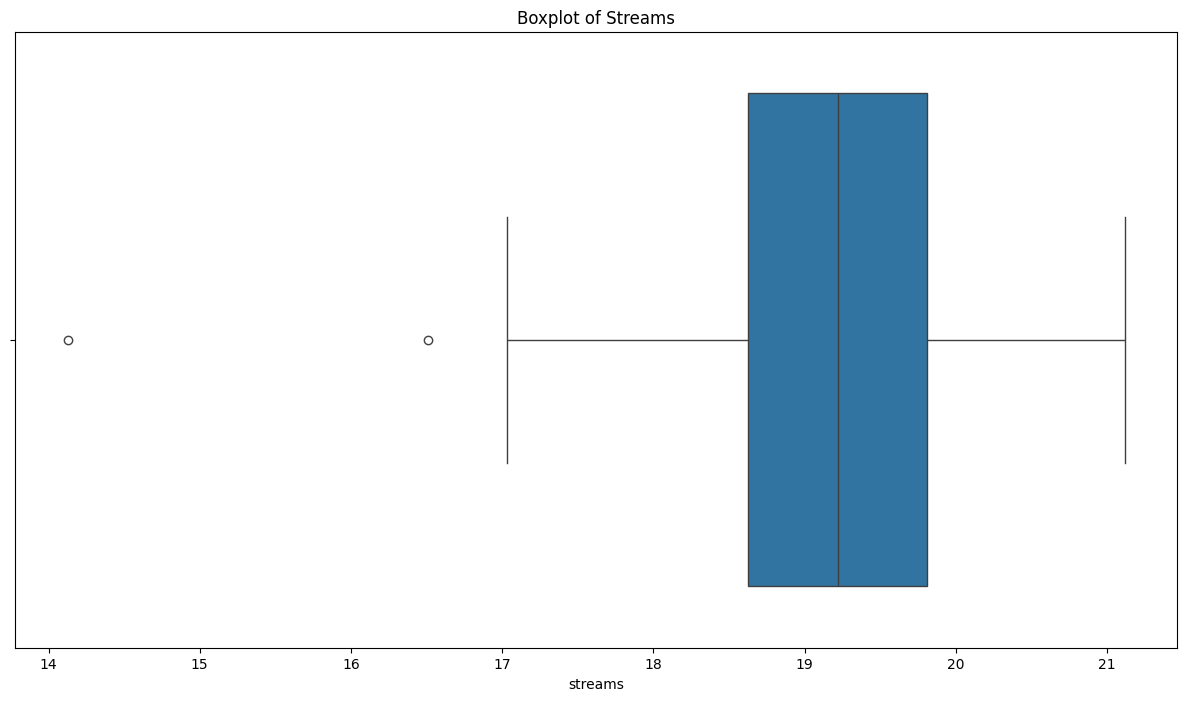

In [750]:
# Boxplot to see outliers removed (small scale)
plt.figure(figsize=(20, 8))
songs_without_column = songs.drop(columns=['artist_count','released_month','released_day','released_year','streams', 'in_spotify_playlists','in_shazam_charts','in_apple_charts','in_apple_playlists', 'in_deezer_playlists'])
sns.boxplot(data=songs_without_column, orient="h", width=0.5)
plt.title('Boxplot of Features')
plt.show()

# Boxplot to see outliers removed (large scale)
plt.figure(figsize=(15, 8))
columns = ['in_apple_playlists', 'in_deezer_playlists','in_shazam_charts','in_apple_charts']
sns.boxplot(data=songs[columns], orient="h", width=0.5)
plt.title('Boxplot of Features')
plt.show()

# Boxplot to see in_spotify_playlists transformed
plt.show()
plt.figure(figsize=(15, 8))
sns.boxplot(x=songs['in_spotify_playlists'])
plt.title('Boxplot of in_spotify_playlists')
plt.show()

# Boxplot to see streams transformed
plt.figure(figsize=(15, 8))
sns.boxplot(x=songs['streams'])
plt.title('Boxplot of Streams')
plt.show()


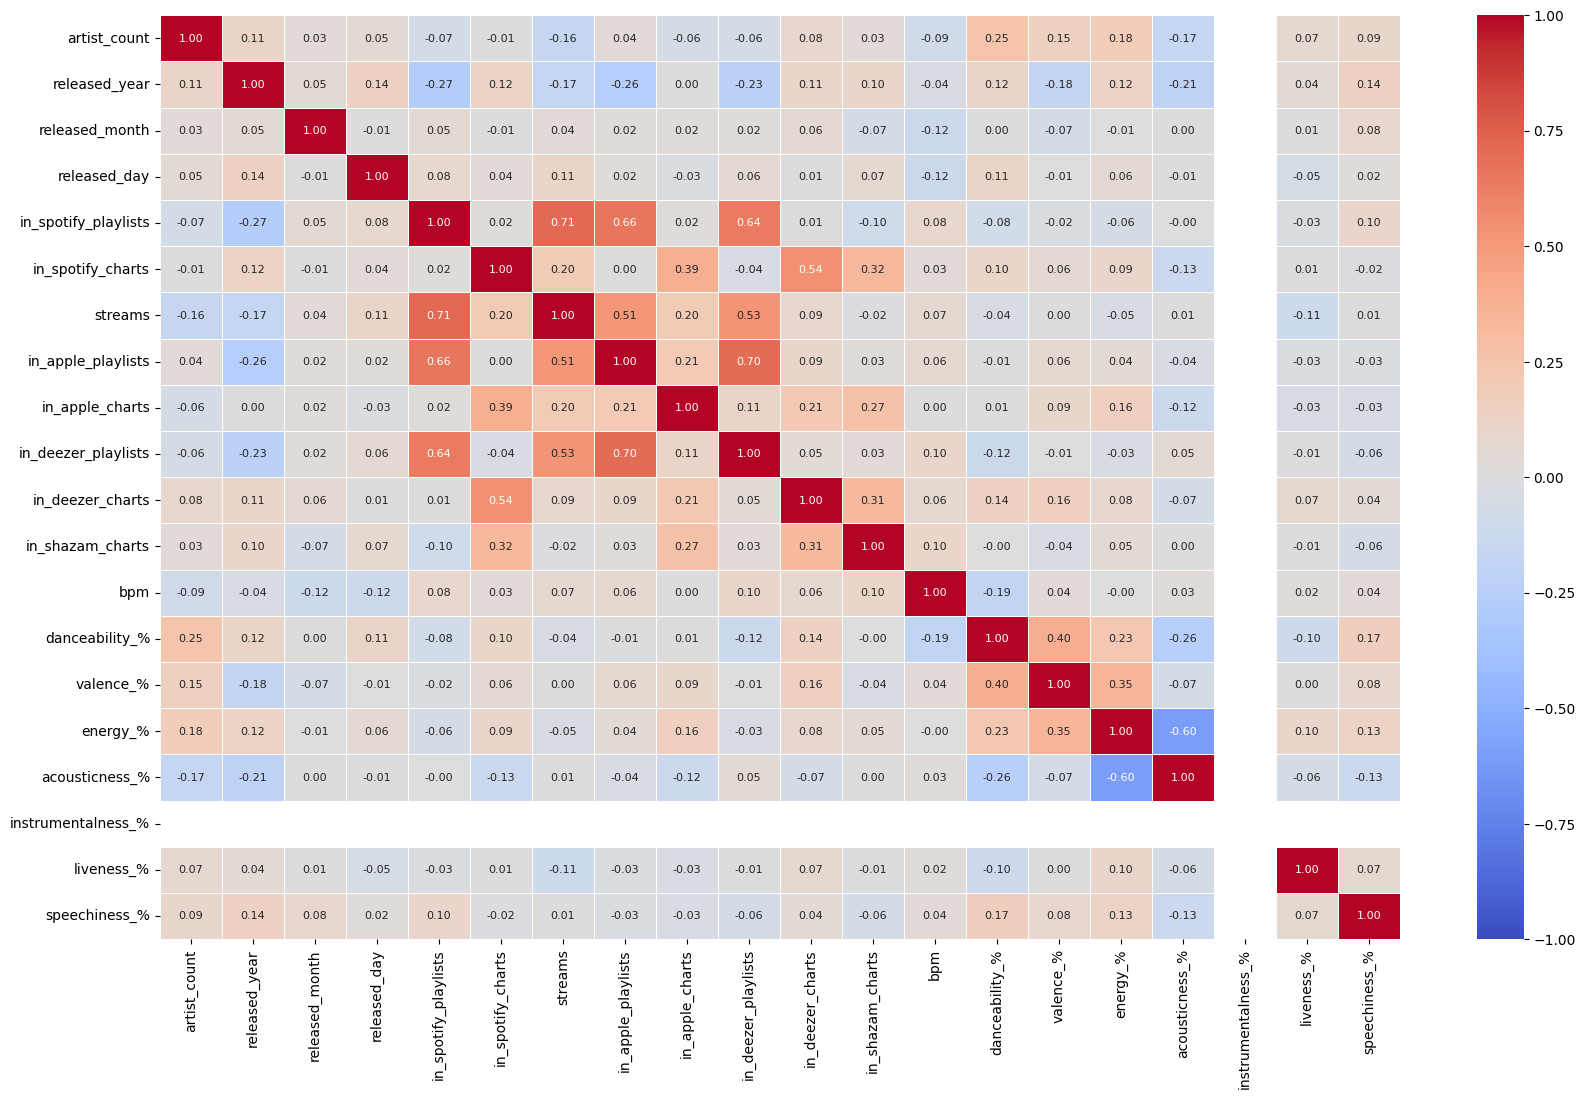

streams               in_spotify_playlists    0.711703
in_spotify_playlists  streams                 0.711703
in_deezer_playlists   in_apple_playlists      0.695766
in_apple_playlists    in_deezer_playlists     0.695766
                      in_spotify_playlists    0.656451
in_spotify_playlists  in_apple_playlists      0.656451
                      in_deezer_playlists     0.636595
in_deezer_playlists   in_spotify_playlists    0.636595
acousticness_%        energy_%               -0.601587
energy_%              acousticness_%         -0.601587
dtype: float64


In [751]:
# Correlation Calculations

# Get Numeric Values
songs_numeric_columns = songs.select_dtypes(include=[np.number])

# Compute the Correlation Matrix
corr_matrix = songs_numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, vmin=-1, vmax=1, linewidths=0.5)
plt.show()

# Prints Top 10 strongest correlations
corr_pairs = corr_matrix.unstack()
sorted_corr = corr_pairs.sort_values(key=abs, ascending=False)
# Drop self-correlations by filtering out correlations of 1
sorted_corr = sorted_corr[sorted_corr != 1]
print(sorted_corr.head(10))

In [752]:
# Encoding

#Binary Encoding
songs['mode'] = songs['mode'].map({'Major': 1, 'Minor': 0})

# One Hot Encoding
songs = pd.get_dummies(songs, columns=['key'])

#Label Encoding
#le = LabelEncoder()
#songs['track_name'] = le.fit_transform(songs['track_name'])
#songs['artist(s)_name'] = le.fit_transform(songs['artist(s)_name'])

print(songs.head())

    artist_count  released_year  released_month  released_day  \
20             3           2023               6            22   
40             2           2023               2            10   
62             3           2022               6            24   
68             1           2023               7            14   
69             1           2023               7             7   

    in_spotify_playlists  in_spotify_charts    streams  in_apple_playlists  \
20              5.808142                 26  18.275017                  11   
40              6.541030                 25  19.686206                  10   
62              8.041735                 39  20.395365                  38   
68              6.018593                 36  16.508814                  36   
69              5.003946                 24  17.493788                  32   

    in_apple_charts  in_deezer_playlists  ...  key_A#  key_B  key_C#  key_D  \
20              163                   10  ...   False  False 

In [753]:
# Normalization of Data

# Initialize the scaler
scaler = MinMaxScaler()
columns_to_normalize = ['streams', 'in_spotify_playlists','in_shazam_charts','in_apple_charts', 'in_deezer_charts', 'in_spotify_charts', 'in_apple_playlists', 'in_deezer_playlists', 'bpm', 'danceability_%', 'energy_%', 'valence_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%','acousticness_%']

# Fit and transform the selected columns
songs_normalized = songs.copy()
songs_normalized[columns_to_normalize] = scaler.fit_transform(songs[columns_to_normalize])

print(songs_normalized[columns_to_normalize].head())


     streams  in_spotify_playlists  in_shazam_charts  in_apple_charts  \
20  0.593499              0.350687          0.000000         0.900552   
40  0.795403              0.464774          0.756098         0.591160   
62  0.896865              0.698385          0.000000         0.000000   
68  0.340803              0.383448          0.317073         0.176796   
69  0.481726              0.225500          0.060976         0.513812   

    in_deezer_charts  in_spotify_charts  in_apple_playlists  \
20               0.8           0.666667            0.056410   
40               0.6           0.641026            0.051282   
62               0.0           1.000000            0.194872   
68               0.2           0.923077            0.184615   
69               0.4           0.615385            0.164103   

    in_deezer_playlists       bpm  danceability_%  energy_%  valence_%  \
20             0.028090  0.572519        0.544118  0.701299   0.892473   
40             0.016854  0.603053 

In [754]:
# Save the normalized data to a new CSV file
songs_normalized.to_csv("normalized_spotify_data.csv", index=False)